In [1]:
from timm import create_model

In [2]:
from fastai.vision.all import *

In [3]:
set_seed(999, reproducible=True)
BATCH_SIZE = 8

In [4]:
dataset_path = Path('../datasets/kaggle/petfinder/')
dataset_path.ls()

(#10) [Path('../datasets/kaggle/petfinder/train_5folds.csv'),Path('../datasets/kaggle/petfinder/train_10folds.csv'),Path('../datasets/kaggle/petfinder/test.csv'),Path('../datasets/kaggle/petfinder/train.csv'),Path('../datasets/kaggle/petfinder/test'),Path('../datasets/kaggle/petfinder/sample_submission.csv'),Path('../datasets/kaggle/petfinder/archive.zip'),Path('../datasets/kaggle/petfinder/train'),Path('../datasets/kaggle/petfinder/crop'),Path('../datasets/kaggle/petfinder/petfinder-pawpularity-score.zip')]

In [5]:
df = pd.read_csv(dataset_path/'train.csv')
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [6]:
df['path'] = df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
df = df.drop(columns=['Id'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../datasets/kaggle/petfinder/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../datasets/kaggle/petfinder/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../datasets/kaggle/petfinder/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../datasets/kaggle/petfinder/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../datasets/kaggle/petfinder/train/7b77e1a6d93667b575d57db83facd860.jpg


In [7]:
len_df = len(df)
print(f"There are {len_df} images")

There are 9912 images


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444


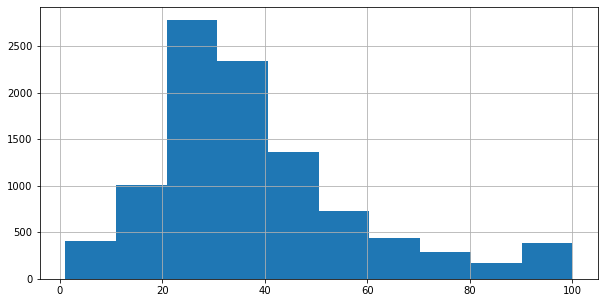

In [8]:
df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {df['Pawpularity'].std()}")

In [9]:
df['norm_score'] = df['Pawpularity']/100
df['norm_score']

0       0.50
1       0.25
2       0.27
3       0.19
4       0.27
        ... 
9907    0.26
9908    0.65
9909    0.38
9910    0.44
9911    0.62
Name: norm_score, Length: 9912, dtype: float64

In [10]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [11]:
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(df)))))
# num_bins

<AxesSubplot:>

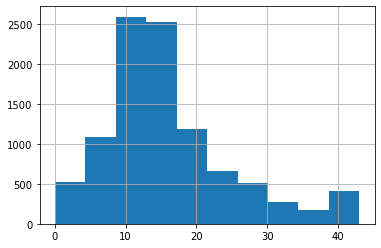

In [12]:
df['bins'] = pd.cut(df['norm_score'], bins=num_bins, labels=False)
df['bins'].hist()

In [13]:
import torch
import torch.nn as nn

class PetModel_swin(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('swin_large_patch4_window7_224', num_classes=num_classes, pretrained=True)

    def forward(self, x):
        features = self.model.forward_features(x)
        pred = self.model.head(features)
        return pred

class PetModel_beit(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('beit_large_patch16_224', num_classes=num_classes, pretrained=True)

    def forward(self, x):
        features = self.model.forward_features(x)
        pred = self.model.head(features)
        return pred
    
class PetModel_vit(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('vit_large_patch16_224', num_classes=num_classes, pretrained=True)

    def forward(self, x):
        features = self.model.forward_features(x)
        pred = self.model.head(features)
        return pred
    
    
class PetModelForCB_swin(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('swin_large_patch4_window7_224', num_classes=num_classes, pretrained=True)

    def forward(self, x):
        features = self.model.forward_features(x)
        pred = self.model.head(features)
        out = torch.cat([pred, features], dim=1)
        return out  

class PetModelForCB_beit(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('beit_large_patch16_224', num_classes=num_classes, pretrained=True)

    def forward(self, x):
        features = self.model.forward_features(x)
        pred = self.model.head(features)
        out = torch.cat([pred, features], dim=1)
        return out    
    
class PetModelForCB_vit(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('vit_large_patch16_224', num_classes=num_classes, pretrained=True)

    def forward(self, x):
        features = self.model.forward_features(x)
        pred = self.model.head(features)
        out = torch.cat([pred, features], dim=1)
        return out
    

# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('tf_efficientnet_b0', num_classes=num_classes, pretrained=False)

#     def forward(self, x):
#         x = self.model.forward_features(x)
#         x = self.model.global_pool(x)
#         if self.model.drop_rate > 0.:
#             x = F.dropout(x, p=self.model.drop_rate, training=self.model.training)
#         return self.model.classifier(x)

# class PetModelForCB(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('tf_efficientnet_b0', num_classes=num_classes, pretrained=False)

#     def forward(self, x):
#         self.eval()
#         features = self.model.forward_features(x)
#         features = self.model.global_pool(features)
#         if self.model.drop_rate > 0.:
#             features = F.dropout(features, p=self.model.drop_rate, training=self.model.training)
#         pred = self.model.classifier(features)
#         out = torch.cat([pred, features], dim=1)
#         return out

In [14]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [15]:
import gc
import torch
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

df['fold'] = -1

super_final_predictions = []
super_final_predictions2 = []
super_final_predictions3 = []
super_final_oof_predictions = []
super_final_oof_predictions2 = []
super_final_oof_predictions3 = []
super_final_oof_true = []


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for fold, (idx, val_idx) in enumerate(strat_kfold.split(df.index, df['bins'])):
    train_df = df.loc[idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)

    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms

    model_swin = PetModelForCB_swin(num_classes=1)
    model_beit = PetModelForCB_beit(num_classes=1)
    model_vit = PetModelForCB_vit(num_classes=1)

    learn_swin = Learner(
        dls, 
        model_swin, 
        loss_func=BCEWithLogitsLossFlat(), 
        metrics=petfinder_rmse,
        model_dir = "swin_large_patch4_window7_224_bs8_10fold_mixup"
    ).to_fp16()
    learn_swin.load(f'swin_large_patch4_window7_224_fold{fold}')
    
    learn_beit = Learner(
        dls, 
        model_beit, 
        loss_func=BCEWithLogitsLossFlat(), 
        metrics=petfinder_rmse,
        model_dir = "beit_large_patch16_224_bs8_10fold_mixup"
    ).to_fp16()
    learn_beit.load(f'beit_large_patch16_224_fold{fold}')
    
    learn_vit = Learner(
        dls, 
        model_vit, 
        loss_func=BCEWithLogitsLossFlat(), 
        metrics=petfinder_rmse,
        model_dir = "vit_large_patch16_224_bs8_10fold_mixup"
    ).to_fp16()
    learn_vit.load(f'vit_large_patch16_224_fold{fold}')


    val_dl = dls.test_dl(val_df)

    swin_val_preds, _ = learn_swin.tta(dl=val_dl, n=5, beta=0)
    swin_val_preds = swin_val_preds.cpu().detach().numpy()
    
    final_test_predictions = []
    final_test_predictions.extend(swin_val_preds[:,:1].ravel().tolist())
    final_test_predictions = [x * 100 for x in final_test_predictions]
    super_final_predictions.append(final_test_predictions)


    beit_val_preds, _ = learn_beit.tta(dl=val_dl, n=5, beta=0)
    beit_val_preds = beit_val_preds.cpu().detach().numpy()
    
    final_test_predictions2 = []
    final_test_predictions2.extend(beit_val_preds[:,:1].ravel().tolist())
    final_test_predictions2 = [x * 100 for x in final_test_predictions2]
    super_final_predictions2.append(final_test_predictions2)

    vit_val_preds, _ = learn_vit.tta(dl=val_dl, n=5, beta=0)
    vit_val_preds = vit_val_preds.cpu().detach().numpy()
    
    final_test_predictions3 = []
    final_test_predictions3.extend(vit_val_preds[:,:1].ravel().tolist())
    final_test_predictions3 = [x * 100 for x in final_test_predictions3]
    super_final_predictions3.append(final_test_predictions3)

    
    final_oof_true = val_df['Pawpularity'].values
    super_final_oof_true.append(final_oof_true)

    ##################
    # COMPUTE RSME
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_predictions[-1]))**2.0 ) )
    print(f'Fold{fold} Swin NN RSME =',rsme,'\n')
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_predictions2[-1]))**2.0 ) )
    print(f'Fold{fold} Beit NN RSME =',rsme,'\n')
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_predictions3[-1]))**2.0 ) )
    print(f'Fold{fold} Vit NN RSME =',rsme,'\n')

    w1, w2, w3 = 0.5, 0.4, 0.1
    oof2 = w1*np.array(super_final_predictions[-1]) + w2*np.array(super_final_predictions2[-1]) + w3*np.array(super_final_predictions3[-1])
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - oof2)**2.0 ) )
    print(f'Fold{fold} Ensemble RSME =',rsme,'\n')

gc.collect()
torch.cuda.empty_cache()
    

/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold0 Swin NN RSME = 17.59280291058582 

Fold0 Beit NN RSME = 17.792923577466944 

Fold0 Vit NN RSME = 17.852725075612227 

Fold0 Ensemble RSME = 17.401751520430654 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold1 Swin NN RSME = 17.064103469489712 

Fold1 Beit NN RSME = 17.155231113097337 

Fold1 Vit NN RSME = 17.597134389417917 

Fold1 Ensemble RSME = 16.83461909268195 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold2 Swin NN RSME = 17.89858944888401 

Fold2 Beit NN RSME = 17.809983453226867 

Fold2 Vit NN RSME = 18.12926118714461 

Fold2 Ensemble RSME = 17.68528134812497 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold3 Swin NN RSME = 17.063153465968377 

Fold3 Beit NN RSME = 17.35090206971495 

Fold3 Vit NN RSME = 17.608946512650515 

Fold3 Ensemble RSME = 16.90498392324367 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold4 Swin NN RSME = 18.013797956079998 

Fold4 Beit NN RSME = 18.077316569862518 

Fold4 Vit NN RSME = 18.65775895616903 

Fold4 Ensemble RSME = 17.88016760430026 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold5 Swin NN RSME = 17.08671060824816 

Fold5 Beit NN RSME = 17.23391088609033 

Fold5 Vit NN RSME = 17.222583505722874 

Fold5 Ensemble RSME = 16.869197401211295 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold6 Swin NN RSME = 17.71255108556369 

Fold6 Beit NN RSME = 17.764415196833294 

Fold6 Vit NN RSME = 18.469748635464054 

Fold6 Ensemble RSME = 17.552469104074152 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold7 Swin NN RSME = 18.08414816057283 

Fold7 Beit NN RSME = 18.017230501493916 

Fold7 Vit NN RSME = 18.854617383204513 

Fold7 Ensemble RSME = 17.80581644282251 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold8 Swin NN RSME = 17.366508133893454 

Fold8 Beit NN RSME = 17.513225263238592 

Fold8 Vit NN RSME = 17.786172593447336 

Fold8 Ensemble RSME = 17.245441049150518 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold9 Swin NN RSME = 16.92437778426538 

Fold9 Beit NN RSME = 17.389583026243283 

Fold9 Vit NN RSME = 17.527611866099903 

Fold9 Ensemble RSME = 16.914326521156582 



In [16]:
true = np.hstack(super_final_oof_true)

oof = np.hstack(super_final_predictions)
rsme = np.sqrt( np.mean( (oof - true)**2.0 ))
print('Overall CV Swin NN head RSME =',rsme)

oof2 = np.hstack(super_final_predictions2)
rsme = np.sqrt( np.mean( (oof2 - true)**2.0 ))
print('Overall CV Beit NN head RSME =',rsme)

oof3 = np.hstack(super_final_predictions3)
rsme = np.sqrt( np.mean( (oof3 - true)**2.0 ))
print('Overall CV Vit NN head RSME =',rsme)


oof4 = w1*oof + w2*oof2 + w3*oof3
rsme = np.sqrt( np.mean( (oof4 - true)**2.0 ))
print('Overall CV Ensemble heads RSME with 50% Swin and 30% Beit and 20% Vit =',rsme)

Overall CV Swin NN head RSME = 17.485547747948647
Overall CV Beit NN head RSME = 17.613155628622746
Overall CV Vit NN head RSME = 17.97784337952811
Overall CV Ensemble heads RSME with 50% Swin and 30% Beit and 20% Vit = 17.31376836260132


In [17]:
import matplotlib.pyplot as plt

score = []
for ww1 in np.arange(0,1.05,0.05):
    for ww2 in np.arange(0, 1.05-ww1, 0.05):
        oof4 = (1-ww1-ww2)*oof + ww1*oof2 + ww2*oof3
        rsme = np.sqrt( np.mean( (oof4 - true)**2.0 ))
        print(f'{ww1:0.2} and {ww2:0.2} CV Ensemble RSME =',rsme)
        score.append(rsme)
        
best_w = np.argmin(score)*0.05

# print(best_w)

# plt.figure(figsize=(20,5))
# plt.plot(np.arange(21)/20.0,score,'-o')
# plt.plot([best_w],np.min(score),'o',color='black',markersize=15)
# plt.title(f'Best Overall CV RSME={np.min(score):.4} with SVR Ensemble Weight={best_w:.2}',size=16)
# plt.ylabel('Overall Ensemble RSME',size=14)
# plt.xlabel('SVR Weight',size=14)
# plt.show()


0.0 and 0.0 CV Ensemble RSME = 17.485547747948647
0.0 and 0.05 CV Ensemble RSME = 17.4597273274936
0.0 and 0.1 CV Ensemble RSME = 17.439227118150388
0.0 and 0.15 CV Ensemble RSME = 17.424065898343223
0.0 and 0.2 CV Ensemble RSME = 17.414257612788234
0.0 and 0.25 CV Ensemble RSME = 17.409811308646308
0.0 and 0.3 CV Ensemble RSME = 17.41073109390169
0.0 and 0.35 CV Ensemble RSME = 17.417016118411663
0.0 and 0.4 CV Ensemble RSME = 17.428660577830943
0.0 and 0.45 CV Ensemble RSME = 17.44565374036856
0.0 and 0.5 CV Ensemble RSME = 17.467979996090072
0.0 and 0.55 CV Ensemble RSME = 17.495618928238596
0.0 and 0.6 CV Ensemble RSME = 17.528545405818722
0.0 and 0.65 CV Ensemble RSME = 17.566729696472443
0.0 and 0.7 CV Ensemble RSME = 17.61013759847933
0.0 and 0.75 CV Ensemble RSME = 17.658730590537765
0.0 and 0.8 CV Ensemble RSME = 17.712465997832805
0.0 and 0.85 CV Ensemble RSME = 17.771297172771117
0.0 and 0.9 CV Ensemble RSME = 17.835173688665677
0.0 and 0.95 CV Ensemble RSME = 17.90404154458